In [6]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier
import test as tt


### 文件读取、数据划分

In [7]:
def readfile():
    df = pd.read_csv('train_feature.csv')
    p = df.isnull().any(axis=1)
    df.dropna(inplace=True)
    X = np.array(df.values)
    y = np.loadtxt('train_label.csv', skiprows=1, dtype="int")
    y = y[(p == False)]
    df2 = pd.read_csv('test_feature.csv')
    df2.fillna(df2.median(), inplace=True)
    X2 = np.array(df2.values)
    return X, y, X2

def drop_err(X, y):
    out = []
    for i in range(X[0].size):
        t = abs(np.mean(X.T[i]))
        for j in range(X.shape[0]):
            if abs(X[j][i]) > t * 5e2:
                out.append(j)
    return np.delete(X, out, axis=0), np.delete(y, out)

def choose_feature(X, y, X2):
    clf = LR(penalty="l1")
    model = RFE(estimator=clf, n_features_to_select=85, step=5)
    X = model.fit_transform(X, y)
    X2 = model.transform(X2)
    model = RFE(estimator=DecisionTreeClassifier(), n_features_to_select=60, step=5)
    X = model.fit_transform(X, y)
    X2 = model.transform(X2)
    return X, y, X2

def score(yp, y):
    return float(np.sum(yp == y))/y.size

X0, y0, X2 = readfile()
X0, y0 = drop_err(X0, y0)
X0, y0, X2 = choose_feature(X0, y0, X2)

In [8]:
def partition(X, y):
    t = (int)(0.7 * y.size)
    index = np.random.permutation(y.size)
    X = X[index]
    y = y[index]
    X_train = X[0:(t-1),:]
    X_test = X[t:(y.size-1),:]
    y_train = y[0:(t-1)]
    y_test = y[t:(y.size-1)]
    return X_train, X_test, y_train, y_test

### 测试

In [9]:
def test(X0, y0, n):
    acc = np.zeros([5, n])
    dif = np.zeros([10, n])
    for j in range(n):
        X, X_t, y, y_t = partition(X0, y0)
        res = np.zeros([5, y_t.size], dtype="int")
        res[1] = tt.test_tree(X, y, X_t)
        res[2] = tt.test_mlp(X, y, X_t)
        res[3] = tt.test_xgb(X, y, X_t)
        res[4] = tt.test_svm(X, y, X_t)
        res[0] = tt.test_lr(X, y, X_t)
        for i in range(5):
            acc[i][j] = score(res[i], y_t)
        count = 0
        for i in range(4):
            for k in range(i+1, 5):
                dif[count][j] = 1 - score(res[i], res[k])
                count += 1
    return acc, dif

average acc:
[0.25546976 0.25072072 0.24934363 0.25633205 0.25487773]
lr's dif with other 4:
[0.72671815 0.74487773 0.74217503 0.6748906 ]
tree's dif with other 3:
[0.73921493 0.69723295 0.73745174]
mlp's dif with other 2:
[0.72788932 0.74660232]
xgb's dif with svm:
[0.73662806]


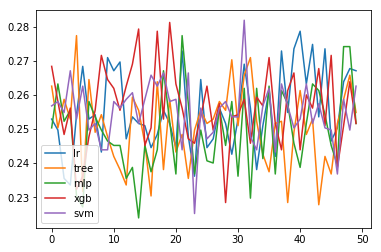

In [10]:
def draw_result(X0, y0, n):
    acc, dif = test(X0, y0, n)
    plt.plot(acc[0], label="lr")
    plt.plot(acc[1], label="tree")
    plt.plot(acc[2], label="mlp")
    plt.plot(acc[3], label="xgb")
    plt.plot(acc[4], label="svm")
    plt.legend()
    print("average acc:")
    print(np.average(acc, axis=1))
    dif_a = np.average(dif, axis=1)
    print("lr's dif with other 4:")
    print(dif_a[0:4])
    print("tree's dif with other 3:")
    print(dif_a[4:7])
    print("mlp's dif with other 2:")
    print(dif_a[7:9])
    print("xgb's dif with svm:")
    print(dif_a[9:10])
    
draw_result(X0, y0, 50)

### 输出

In [12]:
from xgboost import XGBClassifier

def test_xgb(X, y, X_t, X2):
    c = XGBClassifier(n_estimators=60, max_depth=15)
    c.fit(X, y)
    return c.predict(X_t), c.predict(X2)

def show_result(X0, y0, X2):
    m = 0
    ave = 0
    for _ in range(100):
        X, X_t, y, y_t = partition(X0, y0)
        res, r2 = test_xgb(X, y, X_t, X2)
        t = score(res, y_t)
        ave += t
        if (t > m):
            m = t
            predict_now = r2
    print("max acc: " + str(m))
    print("average: " + str(ave / 100))
    return predict_now

predict = show_result(X0, y0, X2)

max acc: 0.2812097812097812
average: 0.25332689832689825


In [ ]:
#with open("test_label.csv", "w") as fi:
    #print("label", file=fi)
    #for i in predict: print(i, file=fi)